# Problem 1: Linear Regression

In this problem we will try to predict the median home value in a given Census area by using linear regression. The data is in `housing_data.mat`, and it comes from http://lib.stat.cmu.edu/datasets/ (`houses.zip`). There are only 8 features for each data point; you can read about the features in `housing_data_source.txt`.

1.) Implement a linear regression model with least squares. Include your code in the submission. You should add a constant term to the training data (e.g. add another dimension to each data point, with the value of 1). This is same as adding the bias term to linear regression (see discussion 4 question 1).

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

housing  = scipy.io.loadmat('data/housing_data.mat')
h_Xtrain = np.asmatrix(housing['Xtrain'])
h_Ytrain = np.asmatrix(housing['Ytrain'])
h_Xtest  = np.asmatrix(housing['Xvalidate'])
h_Ytest  = np.asmatrix(housing['Yvalidate'])

def add_ones(X):
    m = X.shape[0]
    ones = np.ones((m, 1))
    X1 = np.hstack((ones, X))
    return X1

def least_squares(X, y):
    X1 = add_ones(X)
    X1_T = X1.T
    w = np.linalg.inv(X1_T*X1)*X1_T*y
    return w

def rss_calc(y, y_hat):
    rss = np.sum(np.square(y-y_hat))
    return rss

def predict(X, w):
    X1 = add_ones(X)
    y_hat = X1*w
    return y_hat

w = least_squares(h_Xtrain, h_Ytrain)

2.) Test your trained model on the validation set. What is the residual sum of squares (RSS) on the validation set? What is the range of predicted values? Do they make sense?

**Answer:** It seems strange for a house to have a negative value.

In [2]:
h_Ytest_hat = predict(h_Xtest, w)
print("RSS: {0:.1f}".format(rss_calc(h_Ytest, h_Ytest_hat)))
print("Min: {0:.1f}".format(np.min(h_Ytest_hat)))
print("Max: {0:.1f}".format(np.max(h_Ytest_hat)))

RSS: 5794953797672.5
Min: -56562.8
Max: 710798.8


3.) Plot the regression coefficient $w$ (plot the value of each coefficient against the index of the coefficient). Be sure to exclude the coefficient corresponding to the constant offset you added earlier.

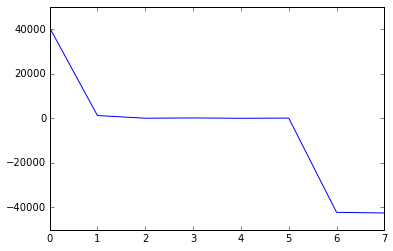

In [3]:
plt.plot(np.arange(8), w[1:])
plt.show()

4.) Plot a histogram of the residuals $(f(x) - y)$. What distribution does this resemble? 

NOTE: You may not use any library routine for linear regression or least squares solving. You may use any other linear algebra routines.

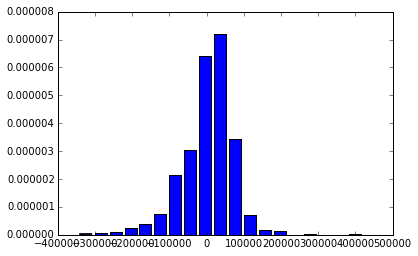

In [4]:
residuals = h_Ytest_hat - h_Ytest
bins = np.linspace(np.min(residuals), np.max(residuals), num=20)
plt.hist(residuals, bins, normed=1, histtype='bar', rwidth=0.8)
plt.show()

# Problem 2: Logistic Regression

Let $\{(x^{(i)}, y^{(i)})^{n}\}_{i=1}$ be a training set, where $x^{i} \in \mathbb{R}^{d}$ and $y^{(i)} \in \{-1, 1\}$. Recall that the loss function for logistic regression is the cross-entropy. Therefore our risk is:

$$R[\mathbf{w}] = \sum^{n}_{i=1} \log(1 + e^{-z^{(i)}})$$

where $f(x) = \mathbf{w}^{T}\mathbf{x}, z^{(i)} = y^{(i)}f(x^{(i)}).$

In this problem you will minimize the cross-entropy risk (also known as the negative log likelihood of $\mathbf{w}$) on a small training set. We have four data points in $\mathbb{R}^{2}$, two of class 1, and two of class -1. Here is the data (and you may want to draw this on paper to see what it looks like):

$$
X =
\begin{bmatrix}
    0 & 3 \\
    1 & 3 \\
    0 & 1 \\
    1 & 1
\end{bmatrix}
, y = 
\begin{bmatrix}
    1 \\
    1 \\
    -1 \\
    -1
\end{bmatrix}
$$

Here, $X$ is the training data matrix; each row $\mathbf{x}^{(i)}$ of $X$ is a data point. Notice that the data cannot be separated by a boundary that goes through the origin. To account for this, you should append 1 to the $\mathbf{x}^{(i)}$ vectors and fit a three-dimensional $\mathbf{w}$ vector that includes an offset term.

1.) Derive the gradient of the cross-entropy risk with respect to $\mathbf{w}$. Show your work. Your answer should be in matrix-vector expression. Do NOT write your answer in terms of the individual components of the gradient. For notation, you may let the $diag(\mathbf{v})$ denote the square matrix with components of vector $\mathbf{v}$ on the diagonal. You may let $Q = diag(\mathbf{y})X$, and you may assume $e^{M}$ is a matrix, where the $i$, $jth$ entry of $e^{M}$ is $e^{M_{ij}}$. Note: Writing these updates as a matrix operations instead of for-loops makes for cleaner code and allows you to take advantage of highly optimized linear algebra routines.

$$\nabla_{w} = -Q^{T} \dfrac {e^{-Qw}}{1 + e^{-Qw}}$$

In [6]:
y = np.array([[ 1], 
              [ 1], 
              [-1],
              [-1]])

X = np.matrix([[0, 3, 1],
               [1, 3, 1],
               [0, 1, 1],
               [1, 1, 1]])

diag_y = np.zeros((y.shape[0], y.shape[0]))
np.fill_diagonal(diag_y, val=y)

Q = diag_y*X

In [8]:
def gradient(Q, w):
    z = Q*w
    return -Q.T * (np.exp(-z)/(1 + np.exp(-z)))

def logistic(z):
    return 1/(1 + np.exp(-z))

def cross_entropy(Q, w):
    return np.sum(np.log(1+np.exp(-Q*w)))

def gd(Q, w, n=1, step=1):
    rs = []
    ws = []
    for i in range(n):
        risk = cross_entropy(Q, w)
        w_new = w - step*gradient(Q, w)
        w = w_new
        rs.append(risk)
        ws.append(w)
    return rs, ws

2.) In general, to verify that the function we minimize is convex we will want to show that the Hessian is positive semi-definite. For now, just derive the Hessian of the risk. Show your work; your answer should be a (somewhat complicated) matrix-vector expression.

3.) We will now perform gradient descent for a few iterations. Set the learning rate ($\eta$) as 1. We are given that $  \begin{equation}
    \mathbf{w}^{(0)}=\begin{bmatrix}
        -2 & 1 & 0
    \end{bmatrix}^{T}
\end{equation}$. $\mathbf{w}^{(0)}$ is the value of $\mathbf{w}$ at the $0^{th}$ iteration.

3a.) State the value of $\mathbf{\mu}^{(0)} = P(Y = 1 | X = x)$. This should be an n-dimensional vector.

In [9]:
w_0 = np.array([[-2],
                [ 1], 
                [ 0]])
mu_0 = logistic(X*w_0)
mu_0

matrix([[ 0.95257413],
        [ 0.73105858],
        [ 0.73105858],
        [ 0.26894142]])

3b.) State the value of $\mathbf{w}^{(1)}$ (the value of $\mathbf{w}$ after one iteration).

In [11]:
w_1 = w_0 - gradient(Q, w_0)
w_1

matrix([[-2.        ],
        [ 0.94910188],
        [-0.68363271]])

3c.) State the value of $\mathbf{\mu}^{(1)}$.

In [12]:
mu_1 = logistic(X*w_1)
mu_1

matrix([[ 0.89693957],
        [ 0.54082713],
        [ 0.56598026],
        [ 0.15000896]])

3d.) After performing a second iteration, state the value of $\mathbf{w}^{(2)}$.

In [13]:
w_2 = w_1 - gradient(Q, w_1)
w_2

matrix([[-1.69083609],
        [ 1.91981257],
        [-0.83738862]])

In [14]:
mu_2 = logistic(X*w_2)
mu_2

matrix([[ 0.99276849],
        [ 0.96199213],
        [ 0.74695242],
        [ 0.35242149]])

# Problem 3: Spam classification using Logistic Regression

The spam dataset given to you as part of the homework in `spam.mat` consists of 4601 email messages, from which 57 features have been extracted as follows:

* 48 features giving the proportion (0 to 1) of words in a given message which match a given word on the list. The list contains words such as business, free, george, etc. (The data was collected by George Forman, so his name occurs quite a lot!)
* 6 features giving the proportion (0 - 1) of characters in the email that match a given character on the list. The characters are `;( [ ! $ #`.
* Feature 55: The average length of an uninterrupted sequence of capital letters
* Feature 56: The length of the longest uninterrupted sequence of capital letters
* Feature 57: The sum of the lengths of uninterrupted sequences of capital letters

The dataset consists of a training set size 3450 and a test set of size 1151. One can imagine performing several kinds of preprocessing to this data matrix. Try each of the following separately:

i. Standardize each column so they each have mean 0 and unit variance.

ii. Transform the features using $x^{(i)}_{j} \leftarrow \log(x^{(i)}_{j} + 0.1)$.

iii. Binarize the features using $x^{(i)}_{j} \leftarrow \mathbb{i}(x^{(i)}_{j} > 0)$. $\mathbb{i}$ denotes an indicator variable.

Note: You will need to tune the step size carefully to avoid numerical issues and to avoid a diverging training risk.

In [16]:
spam = scipy.io.loadmat('data/spam.mat')
s_Xtest  = np.matrix(spam['Xtest'])
s_Xtrain = np.matrix(spam['Xtrain'])
s_Ytrain = np.matrix(spam['Ytrain'])

# preprocess
s_Xtrain_std = add_ones((s_Xtrain-s_Xtrain.mean(axis=0))/s_Xtrain.std(axis=0))
s_Xtrain_log = add_ones(np.log(s_Xtrain + 0.1))
s_Xtrain_bin = add_ones((s_Xtrain > 0).astype(int))

1.) Implement logistic regression to classify the spam data. Use batch gradient descent. Plot the training risk (the cross-entropy risk of the training set) vs. the number of iterations. You should have one plot for each preprocessing method. Note: One batch gradient descent iteration amounts to scanning through the whole training data and computing the full gradient. 

In [17]:
def logistic(z):
    yhat = 1/(1 + np.exp(-z))
    return yhat

def cross_entropy(Q, w):
    return np.sum(np.log(1+np.exp(-Q*w)))

def gradient(Q, w):
    z = Q*w
    return -Q.T * (np.exp(-z)/(1 + np.exp(-z)))

def batch_gd(X, y, iterations, step):
    m, n = X.shape
    diag_y = np.zeros((m, m))
    np.fill_diagonal(diag_y, val=y)
    Q = diag_y*X
    w = np.zeros((n, 1))
    risk_list = []
    while iterations > 0:
        w -= step*gradient(Q, w)
        risk = cross_entropy(Q, w)
        risk_list.append(float(risk))
        iterations -= 1
    return risk_list

def plot_risk(data, labels, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data[0], label=labels[0])
    plt.plot(data[1], label=labels[1])
    plt.plot(data[2], label=labels[2])
    plt.legend(frameon=False)
    plt.ylim([0, 3000])
    plt.ylabel("Cross-Entropy Risk")
    plt.xlabel("Iterations")
    plt.title(title)
    plt.show()

In [18]:
gd_std = batch_gd(s_Xtrain_std, s_Ytrain, 10000, 0.00001)
gd_log = batch_gd(s_Xtrain_log, s_Ytrain, 10000, 0.00001)
gd_bin = batch_gd(s_Xtrain_bin, s_Ytrain, 10000, 0.00001)

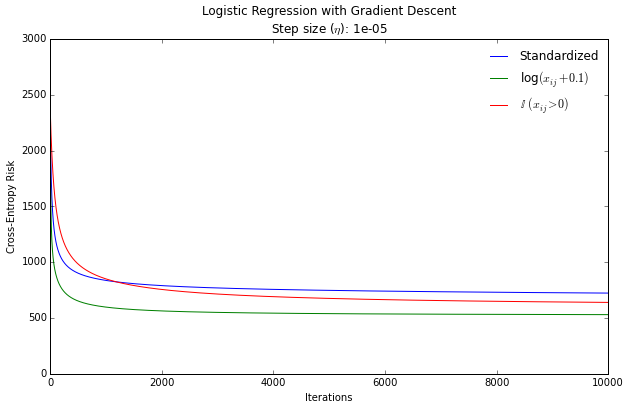

In [19]:
plot_risk(data=[gd_std, gd_log, gd_bin], 
          labels=["Standardized", "log$(x_{ij} + 0.1)$", "$\mathbb{I}$ $(x_{ij} > 0)$"], 
          title=("Logistic Regression with Gradient Descent\nStep size ($\eta$): {}".format(0.00001)))

2.) Derive stochastic gradient descent equations for logistic regression and show your steps. Plot the training risk vs. number of iterations. You should have one plot for each preprocessing method. How are the plots different from (1)? Note: One stochastic gradient descent iteration amounts to computing the gradient using one data point.

**Answer:**

[derive sgd]

The curves for gradient descent appear to have a steeper fall than stochastic gradient descent. Gradient descent also has a lower Negative Log Likelihood for all three feature transformation methods.

In [20]:
def stochastic_gradient(Q, w):
    z = Q*w
    return -Q.T * (np.exp(-z)/(1 + np.exp(-z)))

def sgd(X, y, iterations, step):
    m, n = X.shape
    diag_y = np.zeros((m, m))
    np.fill_diagonal(diag_y, val=y)
    Q = diag_y*X
    w = np.zeros((n, 1))
    risk_list = []
    while iterations > 0:
        i = np.random.randint(0, m)
        w -= step*gradient(Q[i,:], w)
        risk = cross_entropy(Q, w)
        risk_list.append(float(risk))
        iterations -= 1
    return risk_list

In [21]:
sgd_std = sgd(s_Xtrain_std, s_Ytrain, 10000, 0.001)
sgd_log = sgd(s_Xtrain_log, s_Ytrain, 10000, 0.001)
sgd_bin = sgd(s_Xtrain_bin, s_Ytrain, 10000, 0.001)

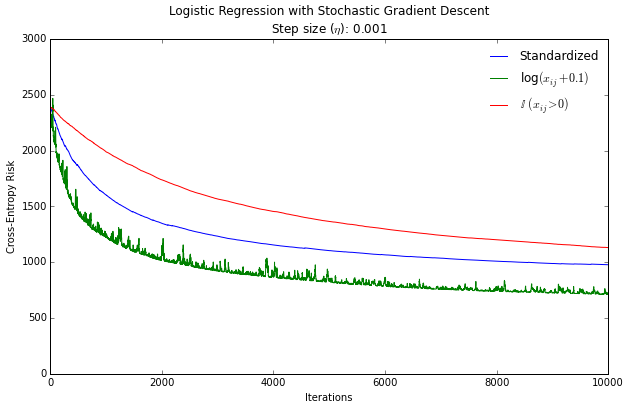

In [22]:
plot_risk(data=[sgd_std, sgd_log, sgd_bin], 
          labels=["Standardized", "log$(x_{ij} + 0.1)$", "$\mathbb{I}$ $(x_{ij} > 0)$"], 
          title=("Logistic Regression with Stochastic Gradient Descent\nStep size ($\eta$): {}".format(0.001)))

3.) Instead of a constant learning rate $(\eta)$, repeat (2) where the learning rate decreases as $\eta \propto 1/t$ for the $t^{th}$ iteration. Plot the training risk vs number of iterations. Is this strategy better than having a constant $ \eta$? You should have one plot for each preprocessing method.

**Answer:** 

This increasing learning rate strategy does not appear to be better than normal stochastic descent.

In [23]:
def sgd_decreasing_rate(X, y, iterations, step):
    m, n = X.shape
    diag_y = np.zeros((m, m))
    np.fill_diagonal(diag_y, val=y)
    Q = diag_y*X
    w = np.zeros((n, 1))
    risk_list = []
    index = 0
    while iterations > 0:
        i = np.random.randint(0, m)
        w -= 1/(index+1)*step*gradient(Q[i,:], w)
        risk = cross_entropy(Q, w)
        risk_list.append(float(risk))
        iterations -= 1
        index += 1
    return risk_list

In [24]:
sgd_decreasing_rate_std = sgd_decreasing_rate(s_Xtrain_std, s_Ytrain, 10000, 1)
sgd_decreasing_rate_log = sgd_decreasing_rate(s_Xtrain_log, s_Ytrain, 10000, 1)
sgd_decreasing_rate_bin = sgd_decreasing_rate(s_Xtrain_bin, s_Ytrain, 10000, 1)

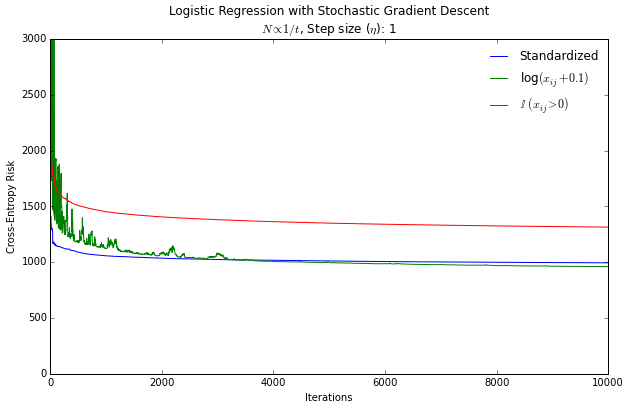

In [25]:
plot_risk(data=[sgd_decreasing_rate_std, sgd_decreasing_rate_log, sgd_decreasing_rate_bin], 
          labels=["Standardized", "log$(x_{ij} + 0.1)$", "$\mathbb{I}$ $(x_{ij} > 0)$"], 
          title=("""Logistic Regression with Stochastic Gradient Descent
$N \propto 1/t$, Step size ($\eta$): {}""".format(1)))

4a.) Now let's use kernel logistic regression with a polynomial kernel of degree 2. Our risk is still the same as in problem 2, but our classifier is now:

$$f(\mathbf{x}) = \sum^{n}_{i = 1} \alpha_{i} K(\mathbf{x}^{(i)}, \mathbf{x}) \textrm{ where } K(\mathbf{x}^{(i)}, \mathbf{x}) = (\mathbf{x}^{T} \mathbf{x}^{(i)} + 1)^{2}$$

instead of $f(\mathbf{x}) = \mathbf{w}^{T}\mathbf{x}$ as it was originally. Show that the stochastic gradient descent update for data point $\mathbf{x}^{(i)}$ is:

$$\alpha_{i} \leftarrow \alpha_{i} + \eta S(-z^{(i)})y^{(i)}$$

$$\textrm{Where } z^{(i)} = y^{(i)} f(\mathbf{x}^{(i)}), S(-z^{(i)}) = \dfrac{1}{1 + exp(z^{(i)})}$$

Note that this measure means $\mathbf{\alpha} \in \mathbb{R}^{n}$. Also derive $\dfrac{\partial L}{\partial \alpha_{i}}$ directly from the loss function. You should get a different answer than the dual algorithm shown above. Under what condition are the two updates you derived the same?

**Answer:**

4b.) Finally, repeat (2), using the best preprocessing method you found, using kernel logistic ridge regression. Use whichever learning rate scheme you wish. Use $\gamma = 10^{-5}$. You  may optionally adjust the value of $\gamma$. Generate a plot of training risk vs. number of iterations, and another plot of validation risk vs. number of iterations (use a 2/3, 1/3
split). Use the following update equations (you do not need to derive them):

$$\alpha_{i} \leftarrow \alpha_{i} - \gamma \alpha_{i} + \eta S(-z^{(i)})y^{(i)}$$

$$\alpha_{h} \leftarrow \alpha_{h} - \gamma \alpha_{h} \textrm{ for } h \neq i$$

In [26]:
def ridge_cross_entropy(Q, w, lmda):
    return np.sum(np.log(1 + np.exp(-Q*w))) - lmda*np.linalg.norm(w)**2

def ridge_gradient(Q, w, lmda):
    z = Q*w
    return 2*lmda*w - Q.T*(np.exp(-z)/(1 + np.exp(-z)))

def ridge_sgd(X, y, iterations, step, lmda):
    m, n = X.shape
    diag_y = np.zeros((m, m))
    np.fill_diagonal(diag_y, val=y)
    Q = diag_y*X
    w = np.zeros((n, 1))
    risk_list = []
    index = 0
    while iterations > 0:
        i = np.random.randint(0, m)
        w -= step*ridge_gradient(Q[i,:], w, lmda)
        risk = ridge_cross_entropy(Q, w, lmda)
        risk_list.append(float(risk))
        iterations -= 1
        index += 1
    return risk_list

In [27]:
ridge_sgd_std = ridge_sgd(s_Xtrain_std, s_Ytrain, 10000, 0.001, 0.01)
ridge_sgd_log = ridge_sgd(s_Xtrain_log, s_Ytrain, 10000, 0.001, 0.01)
ridge_sgd_bin = ridge_sgd(s_Xtrain_bin, s_Ytrain, 10000, 0.001, 0.01)

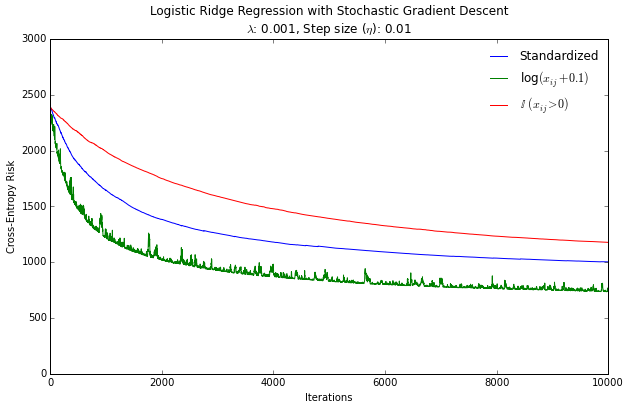

In [28]:
plot_risk(data=[ridge_sgd_std, ridge_sgd_log, ridge_sgd_bin], 
          labels=["Standardized", "log$(x_{ij} + 0.1)$", "$\mathbb{I}$ $(x_{ij} > 0)$"], 
          title=("""Logistic Ridge Regression with Stochastic Gradient Descent
$\lambda$: {}, Step size ($\eta$): {}""".format(0.001, 0.01)))

Repeat the same experiment with the linear kernel $K(\mathbf{x}^{(i)}, \mathbf{x}) = \mathbf{x}^{T} \mathbf{x}^{(i)} + 1$. Does the quadratic kernel overfit the data? For each kernel, should you decrease or increase $\gamma$ to try to improve performance?

NOTE: You are NOT supposed to use any kind of software package for logistic regression!

# Problem 4: Real World Spam Classification

Daniel recently interned as an anti-spam product manager for a large email service provider. His company uses a linear SVM to predict whether an incoming spam message is spam or ham. He notices that the number of spam messages received tends to spike massively upwards a couple minutes before and after midnight. Eager to obtain a return offer, he adds the time-stamp of the received message, stored as number of milliseconds since the previous midnight, to each feature vector for the SVM to train on, in hopes that the ML model will be able to identify the abnormal spike in spam volume at night. To his dismay, after A/B testing with his newly added feature, Daniel discovers that the linear SVM's success rate barely improves. He wants to try to use a kernel to improve his model, but unfortunately he is limited to a quadratic kernel.

Why can't the linear SVM utilize the new feature well, and what can Daniel do to improve his results? This is an actual interview question Daniel received for a machine learning engineering position!

Write a short explanation. This question is open ended and there can be many correct answers. It is not necessary, but feel free to do your own research as long as you cite any sources.